<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [147]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [148]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('data/job_listings.csv')

df.drop(columns = 'Unnamed: 0', inplace = True)
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [168]:
def text_cleaner(doc):
    '''
    A quick and dirty text cleaner.  Takes scrapped text, removes
    HTML, newlines, and a few manually found issues. Returns the
    cleaned text
    '''
    #using beautiful soup to remove the html
    soup = BeautifulSoup(doc, 'html.parser')
    
    cleaned = soup.get_text()
    
    # some manual cleaning. Some of this I could do with stopwords
    # but some of it is embedded between two words. 
    cleaned = cleaned.replace('\\n', ' ')
    cleaned = cleaned.replace('/', ' ')
    
    #unicode bs. I went through a long and arduous journey to try and get some
    #level of auto detection for this unicode encoding.  The take away, that it
    #is not possible, because not every review is encoded the same. So I'm
    #manually removing this bs as I run into it. GROSS
    unicode_mess = ['\\xe2\\x80\\xa6','\\xc2\\xa8', '\\xe2\\x80\\x93', 'b"',
                   "b'", '\\xe2\\x80\\x99']
    
    for code in unicode_mess:
        cleaned = cleaned.replace(code, '')
    
    return cleaned

def text_tokenizer(docs, stop_words = []):
    '''
    A quick helper function to consistently tokenize using spaCy tokenizer
    that I can use accross multiple NLP assignments
    
    Returns a list of tokenized documents
    '''
    import spacy
    from spacy.tokenizer import Tokenizer
    
    nlp = spacy.load("en_core_web_lg")
    tokenizer = Tokenizer(nlp.vocab)
    
    STOP_WORDS = nlp.Defaults.stop_words.union(stop_words)
    
    tokens = []
    
    for doc in tokenizer.pipe(docs, batch_size = 1000):
        
        lemmas = []
        
        for token in doc:
            if (token.text.lower() not in STOP_WORDS) and (token.is_punct == False) and (token.is_space == False) and (token.pos_ != 'PRON'):
                lemmas.append(token.lemma_.lower())
        
        tokens.append(lemmas)
    
    return tokens

In [177]:
df['description_clean'] = df['description'].apply(text_cleaner)

df.head()

,description,title,description_clean
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA multiple locations 2+ years of ...


## 2) Use Spacy to tokenize the listings 

In [181]:
df['tokens'] = text_tokenizer(df['description_clean'])
print(df.shape)
df.head()

(426, 4)


,description,title,description_clean,tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...,"[job, requirements:, conceptual, understand, m..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi...","[job, description, data, scientist, 1,, help, ..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[data, scientist, work, consult, business., re..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener...","[$4,969, $6,756, monthcontractunder, general, ..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA multiple locations 2+ years of ...,"[location:, usa, multiple, location, 2+, year,..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [186]:
vect = CountVectorizer()

#creating a document term matrix
dtm = vect.fit_transform(df['description_clean'])

#since it is simply a matrix without column names, lets make this a bit more
#readable by making a dataframe out of the matrix and using the feature names
#as the columns
dtm = pd.DataFrame(dtm.todense(), columns = vect.get_feature_names())
print(dtm.shape)
dtm.head()

(426, 8844)


,00,000,02115,03,0305,0356,04,062,06366,08,...,zf,zfs,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [191]:
#okay lets do only the top 20 words
#first sum sums all the values in the column, second sum sums all those values
total = dtm.sum().sum()

wc_all = {'word': [], 'count': [], 'percent_total': []}

STOP_WORDS = nlp.Defaults.stop_words

for col in dtm.columns:
    if col not in STOP_WORDS:
        wc_all['word'].append(col)
        wc_all['count'].append(dtm[col].sum())
        wc_all['percent_total'].append(dtm[col].sum() / total)
    
wc_all = pd.DataFrame(wc_all)

wc_all['rank'] = wc_all['count'].rank(method = 'first', ascending = False)
wc_all.sort_values(by = 'rank', inplace = True)
wc_all.head()

,word,count,percent_total,rank
2072,data,4466,0.021683,1.0
2964,experience,1854,0.009001,2.0
1146,business,1212,0.005884,3.0
8411,work,1161,0.005637,4.0
7631,team,973,0.004724,5.0


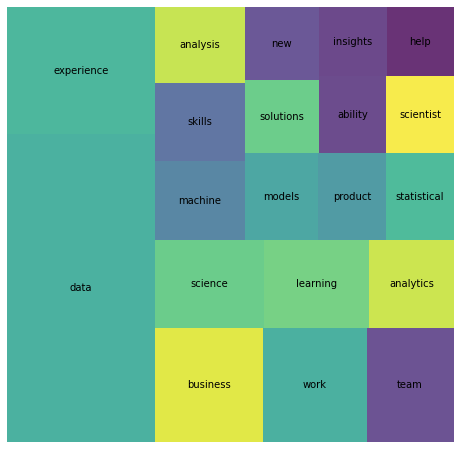

In [192]:
import squarify
import matplotlib.pyplot as plt

all_top20 = wc_all[wc_all['rank'] <= 20]

plt.figure(figsize = (8,8))
squarify.plot(sizes = all_top20['percent_total'], label = all_top20['word'], alpha = .8)
plt.axis('off')
plt.show();

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [193]:
#Term frequency document frequency.

tfidf = TfidfVectorizer(stop_words = 'english',
                       ngram_range = (1,2),
                       min_df = 3,
                       max_df = 0.6,
                       max_features = 5000)

dtm2 = tfidf.fit_transform(df['description_clean'])

dtm2 = pd.DataFrame(dtm2.todense(), columns = tfidf.get_feature_names())

print(dtm2.shape)
dtm2.head()

(426, 5000)


,000,000 employees,10,10 years,100,100 000,100 countries,11,12,12 months,...,york city,youll,youll develop,youll doing,youll need,youll work,youre,youre looking,youve,yrs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [195]:
#okay start by fitting a nearestneighbor model on the tfidf dataframe
#then fit a new tfidf with a description of my ideal job

from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors = 5, algorithm = 'kd_tree')
nn.fit(dtm2)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [198]:
#remember you fit this on your job listing data, so we only want to transform
#our ideal job.

ideal_job = '''
A job where I have agency to choose my own work schedule, my own projects, with
a lot of vacation, and above average compensation.
'''

new = tfidf.transform([ideal_job])

nn.kneighbors(new.todense())

(array([[1.28937773, 1.3328566 , 1.34078389, 1.35034218, 1.35034218]]),
 array([[ 17, 227, 228, 149, 343]]))

In [201]:
df.iloc[17]['description_clean']

"ContractWe are looking to hire for a Data Scientist (Remote).  Qualifications: This job is for a Data Scientist who is an expert in Python. Developer should also have basic experience with postgres database. Goal is to develop a general purpose script that creates various models for user imported datasets and choose the best model for making predictions. Must be American citizen authorized to work in US.  Overview of work : Developer will be working on an already built product that requires new features and bug fixing . Self testing and bug fixing is an important part of the job. Product is a tool that automates machine learning and makes natural language search and predictions on user imported data. Developer will be working on a flexible schedule. He will be part of a remotely working team collaborating through Skype and needs to take part in daily calls.  Job Type: Contract to hire'"

In [202]:
df.iloc[227]['description_clean']

"Agency and Job Overview  We are OMD, an award-winning, integrated, communications agency. Fueled by data and driven by creativity, OMD provides its clients innovative, actionable media & communication strategies to accelerate their business. As a Senior member of OMDs Marketing Sciences team, you will be responsible for delivering on this vision and shaping the strategic direction of our clients. The ideal candidate is someone who can explore, analyze and visualize dynamic datasets, while having technical expertise in building statistical models (supervised and unsupervised). The Supervisor will work closely with the Marketing Sciences Director to manage resources, implement process improvements and mentor junior members of the team. Areas of Responsibility: Exploration and experimentation with large number of datasets to draw insights and search for stories Predictive and descriptive analysis based on OMD and OMG data Maintain data pipelines and visualization outputs Understand and p

In [203]:
df.iloc[228]['description_clean']

"InternshipAbout the role Data Scientist Internship Gap Inc. Technology is looking for exceptional talent with fresh ideas, cutting-edge skills, and a passion for technology. Were not your average IT shop, and this isnt your average internship. In your 10 weeks with Gap Inc. youll have a voice in the room, be pushed to take risks, and play a critical role in innovative projects that are transforming retail technology. Ready to get started? Whats In It for You?  As a Gap Inc. Intern, you will gain valuable work experience in a fast paced and innovative environment, here in beautiful San Francisco. By the end of the 10 weeks you will have completed business critical projects, which you will present to your senior leadership team. Dont expect to be running around getting coffee. Many interns projects have been implemented by the business and are currently driving incredible results for the company. Here at Gap Inc., we like to reward success. You are invited to participate in events, such

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 